!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories for damages: 
damage

COCO supercategories for damages: 
part

COCO categories for parts: 
headlamp, rear_bumper, door, hood, front_bumper

COCO supercategories for parts: 
part

7 image id was selected at random from the [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] list
Image details 
 {'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '74.jpg', 'flickr_url': '', 'height': 1024, 'id': 7, 'license': 1, 'width': 1024}


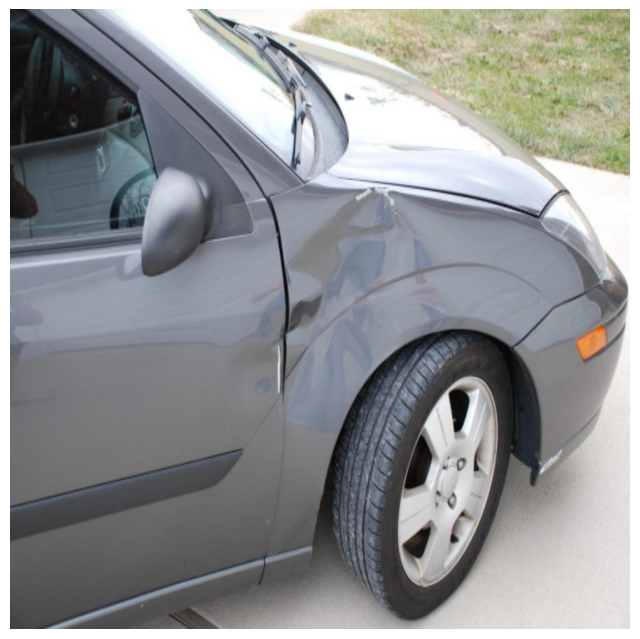

In [10]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image


dataDir='./Dataset/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "./Dataset/img"

coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

# display categories and supercategories

#Single Class #Damage dataset
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories for damages: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories for damages: \n{}\n'.format(', '.join(nms)))

#Multi Class #Parts dataset

mul_cats = mul_coco.loadCats(mul_coco.getCatIds())
mul_nms=[cat['name'] for cat in mul_cats]
print('COCO categories for parts: \n{}\n'.format(', '.join(mul_nms)))

mul_nms = set([mul_cat['supercategory'] for mul_cat in mul_cats])
print('COCO supercategories for parts: \n{}\n'.format(', '.join(mul_nms)))

# get all images containing 'damage' category, select one at random
catIds = coco.getCatIds(catNms=['supercategory']);
imgIds = coco.getImgIds(catIds=catIds );

random_img_id = random.choice(imgIds)
print("{} image id was selected at random from the {} list".format(random_img_id, imgIds))

# Load the image
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)



I = io.imread(img_dir + '/' + img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()



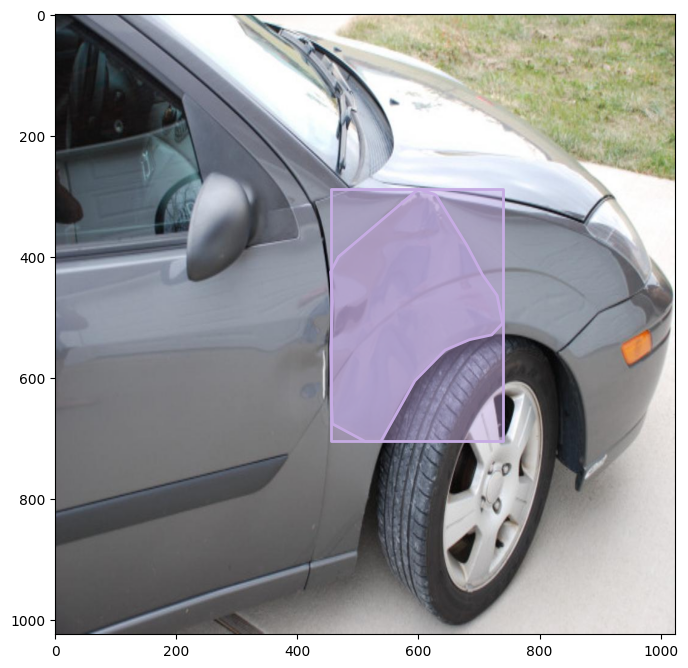

In [12]:

#get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)

#Plot damages
plt.imshow(I)
plt.axis('on')
coco.showAnns(anns, draw_bbox=True )

In [21]:
#get parts annotations
mul_annIds = mul_coco.getAnnIds(imgIds=imgId,iscrowd=None)
mul_anns = mul_coco.loadAnns(mul_annIds)

# Create a dictionary between category_id and category name
category_map = dict()

for ele in list(mul_coco.cats.values()):
    category_map.update({ele['id']:ele['name']})
    
category_map

{1: 'headlamp', 2: 'rear_bumper', 3: 'door', 4: 'hood', 5: 'front_bumper'}

Parts are: ['door', 'hood', 'headlamp', 'front_bumper']


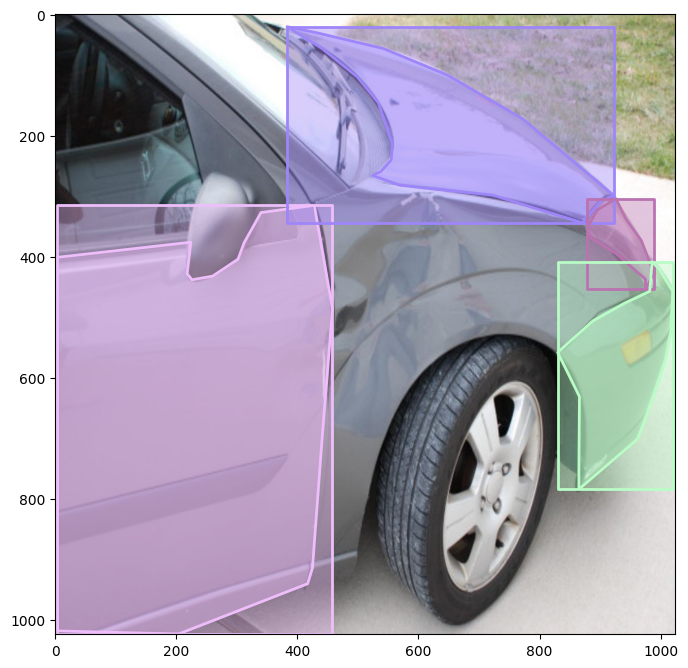

In [22]:
#Create a list of parts in the image
parts = []
for region in mul_anns:
    parts.append(category_map[region['category_id']])

print("Parts are:", parts) 

#Plot Parts
I = io.imread(img_dir + '/' + img['file_name'])
plt.imshow(I)
plt.axis('on')
mul_coco.showAnns(mul_anns, draw_bbox=True )

Training

!git clone https://github.com/facebookresearch/detectron2.git


In [ ]:
import torch, torchvision
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

dataset_dir = "./Dataset"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_train5", {}, os.path.join(dataset_dir,train_dir,"COCO_train_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_dataset_val5", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))

dataset_dicts = DatasetCatalog.get("car_dataset_train5")
metadata_dicts = MetadataCatalog.get("car_dataset_train5")

#Implementing my own Trainer Module here to use the COCO validation evaluation during training
# TODO: add data custom augmentation 
class CocoTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_dataset_train5",)
cfg.DATASETS.TEST = ("car_dataset_val5",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  
cfg.SOLVER.WARMUP_ITERS = 700
cfg.SOLVER.MAX_ITER = 400 
cfg.SOLVER.STEPS = (600, 800)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  
cfg.MODEL.RETINANET.NUM_CLASSES = 2 
cfg.TEST.EVAL_PERIOD = 600

# Set device to CPU
cfg.MODEL.DEVICE = "cpu"  

import os
cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


[10/30 15:57:37 d2.data.datasets.coco]: Loaded 59 images in COCO format from ./Dataset\train/COCO_train_annos.json
[10/30 15:57:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padd

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[10/30 15:57:37 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\walte\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/30 16:06:56 d2.utils.events]:  eta: 3:01:27  iter: 19  total_loss: 2.329  loss_cls: 1.071  loss_box_reg: 0.4173  loss_mask: 0.6949  loss_rpn_cls: 0.2048  loss_rpn_loc: 0.02258    time: 27.8951  last_time: 27.3364  data_time: 0.1492  last_data_time: 0.0020   lr: 4.8453e-05  
[10/30 16:16:09 d2.utils.events]:  eta: 2:49:19  iter: 39  total_loss: 1.849  loss_cls: 0.5605  loss_box_reg: 0.429  loss_mask: 0.6798  loss_rpn_cls: 0.1432  loss_rpn_loc: 0.02184    time: 27.6238  last_time: 23.3460  data_time: 0.0022  last_data_time: 0.0027   lr: 9.8403e-05  
[10/30 16:25:30 d2.utils.events]:  eta: 2:39:55  iter: 59  total_loss: 1.574  loss_cls: 0.3949  loss_box_reg: 0.4294  loss_mask: 0.644  loss_rpn_cls: 0.08251  loss_rpn_loc: 0.02045    time: 27.7805  last_time: 30.4502  data_time: 0.0022  last_data_time: 0.0026   lr: 0.00014835  
[10/30 16:35:28 d2.utils.events]:  eta: 2:31:48  iter: 79  total_loss: 1.509  loss_cls: 0.39  loss_box_reg: 0.461  loss_mask: 0.5985  loss_rpn_cls: 0.05599  loss_

Loading model

In [ ]:
import torch, torchvision
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

plt.rcParams["figure.figsize"] = [16,9]

dataset_dir = "./Dataset"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_train5", {}, os.path.join(dataset_dir,train_dir,"COCO_train_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_dataset_val5", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))

dataset_dicts = DatasetCatalog.get("car_dataset_train5")
metadata_dicts = MetadataCatalog.get("car_dataset_train5")

class CocoTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_dataset_train5",)
cfg.DATASETS.TEST = ("car_dataset_val5",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001 
cfg.SOLVER.WARMUP_ITERS = 700
cfg.SOLVER.MAX_ITER = 400 
cfg.SOLVER.STEPS = (600, 800)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  
cfg.MODEL.RETINANET.NUM_CLASSES = 2 
cfg.TEST.EVAL_PERIOD = 600


cfg.MODEL.DEVICE = "cpu"  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   
cfg.DATASETS.TEST = ("car_dataset_val5", )
predictor = DefaultPredictor(cfg)

val_dataset_dicts = DatasetCatalog.get("car_dataset_val5")
val_metadata_dicts = MetadataCatalog.get("car_dataset_val5")


[10/31 10:12:14 d2.data.datasets.coco]: Loaded 59 images in COCO format from ./Dataset\train/COCO_train_annos.json
[10/31 10:12:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


c:\Users\walte\AppData\Local\Programs\Python\Python312\Lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, 

[10/31 10:12:15 d2.data.datasets.coco]: Loaded 11 images in COCO format from ./Dataset\val/COCO_val_annos.json


In [4]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set up the evaluator for COCO format annotations
evaluator = COCOEvaluator("car_dataset_val5", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "car_dataset_val5")

# Perform inference on the dataset and calculate metrics
metrics = inference_on_dataset(predictor.model, val_loader, evaluator)
print(metrics)


WARNING [10/31 10:12:44 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/31 10:12:44 d2.data.datasets.coco]: Loaded 11 images in COCO format from ./Dataset\val/COCO_val_annos.json
[10/31 10:12:44 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   damage   | 24           |
|            |              |
[10/31 10:12:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/31 10:12:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/31 10:12:44 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[10/31 10:12:44 d2.data.common]: Serialized dataset takes 0.01 MiB
[10/31 10:12:44 d2.evaluation.evaluator]: Start i

c:\Users\walte\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/31 10:13:21 d2.evaluation.evaluator]: Inference done 11/11. Dataloading: 0.0005 s/iter. Inference: 3.0241 s/iter. Eval: 0.0031 s/iter. Total: 3.0277 s/iter. ETA=0:00:00
[10/31 10:13:21 d2.evaluation.evaluator]: Total inference time: 0:00:18.676860 (3.112810 s / iter per device, on 1 devices)
[10/31 10:13:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:18 (3.024111 s / iter per device, on 1 devices)
[10/31 10:13:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/31 10:13:21 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[10/31 10:13:21 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[10/31 10:13:21 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/31 10:13:21 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.00 seconds.
[10/31 10:13:21 d2.evaluation.

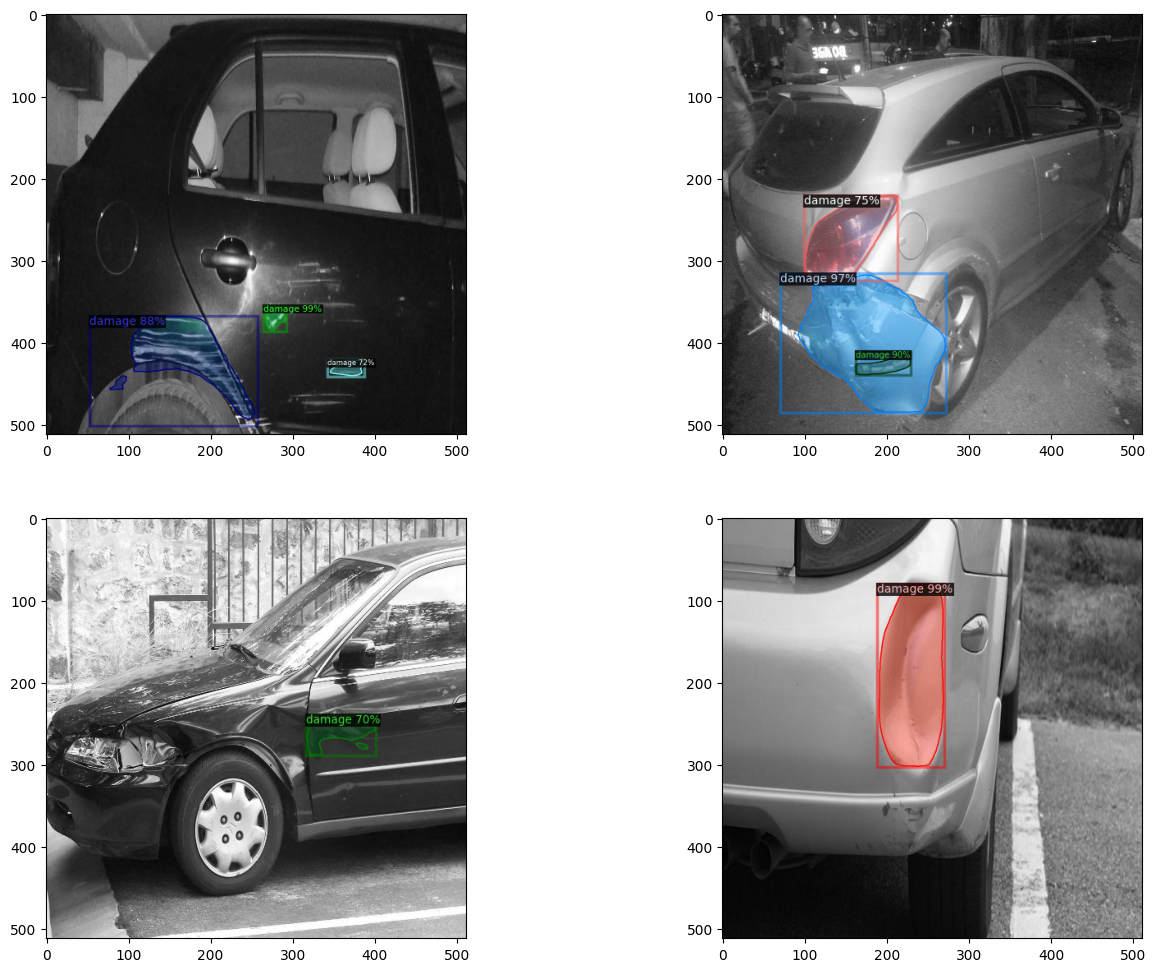

In [ ]:


fig, ax = plt.subplots(2, 2, figsize =(16,12))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(val_dataset_dicts, 4):
    i=i+1    
    im = io.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata_dicts, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW  
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

